In [1]:
#pip install opencv-python
#pip install scikit-image

In [268]:
import numpy as np
import pandas as pd
import gzip
import cv2
import tensorflow as tf
import keras

from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse

from keras import backend
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.initializers import RandomNormal

from keras.optimizers import SGD

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("data/train.csv")

In [4]:
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [6]:
df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [7]:
for c in df.columns:
    print ("---- %s ----" % c)
    print (df[c].value_counts())
    print("\n")

---- Id ----
7473a90c0f7b640d3cb80f14b6a7bf9e    1
9c5867e1c5968f27e99ca05f55135818    1
e7bdb0f023795cbb2d1e237e49982298    1
996a2123efa0aa6df96d14bb767e77bd    1
68a0dc40fbab9a54b61adb3c8bd4edd5    1
                                   ..
934333e4225606d562bce5061d10dcb3    1
a858b80acb6fbbd0b03e9bb7539234c4    1
b18e40e5bdbdefc3c157b445735fab36    1
94c823294d542af6e660423f0348bf31    1
ac877d2e9d2be54570888dfd3e724103    1
Name: Id, Length: 9912, dtype: int64


---- Subject Focus ----
0    9638
1     274
Name: Subject Focus, dtype: int64


---- Eyes ----
1    7658
0    2254
Name: Eyes, dtype: int64


---- Face ----
1    8960
0     952
Name: Face, dtype: int64


---- Near ----
1    8540
0    1372
Name: Near, dtype: int64


---- Action ----
0    9813
1      99
Name: Action, dtype: int64


---- Accessory ----
0    9240
1     672
Name: Accessory, dtype: int64


---- Group ----
0    8630
1    1282
Name: Group, dtype: int64


---- Collage ----
0    9420
1     492
Name: Collage, dtype: in

In [8]:
# Count of null values per column & total
display(df.isna().sum())
print('Total Null Count:', df.isna().sum().sum())

Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64

Total Null Count: 0


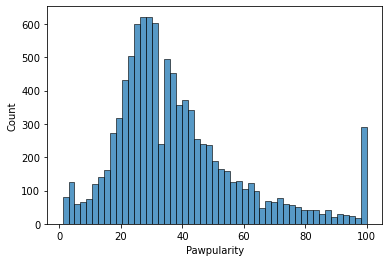

In [81]:
sns.histplot(df['Pawpularity']);

In [12]:
images = []
count = 0
for index in range(len(df)):
    Id = df.loc[index, 'Id']
    path = 'data/train/'+str(Id)+'.jpg'
    img_array = cv2.imread(path)
    img_array = resize(img_array, (64, 64), anti_aliasing=True)
    images.append(img_array)
    count += 1
    progress = (count/len(df))*100
    print('progress =', round(progress,2), '%', end='\r')

In [55]:
X=(np.array(images)/255)

KeyboardInterrupt: 

In [54]:
X.shape

(9912, 64, 64, 3)

In [18]:
y = df['Pawpularity']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Modeling

>Function for model evaluation

In [280]:
def model_compfit(model, X_train, y_train, n_epochs):

    # compile model with adam optimizer and mean squared error metric
    model.compile(optimizer='adam',
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])
    # fit model on train sets with n number epochs
    model.fit(X_train, y_train, epochs=n_epochs)

In [285]:
def model_eval(model, X_train, y_train, X_test, y_test, name):
    
    # calculate training data metrics
    train_eval = model.evaluate(X_train, y_train)
    
    # calculate test data metrics
    test_eval = model.evaluate(X_test, y_test)
    
    # print metrics
    print(f"""
    {name} Training Metrics:
    Loss: {round(train_eval[0] , 3)}
    Root Mean Square Error: {round(train_eval[1] , 3)}
    Cross Validation Score: 
    ------
    {name} Test Metrics:
    Loss: {round(test_eval[0] , 3)}
    Root Mean Square Error: {round(test_eval[1] , 3)}
    """)
    # visualize predictions
    ypred = model.predict(X_test)
    x_ax = range(len(ypred))
    plt.figure(figsize=(20,10))
    plt.scatter(x_ax, y_test, s=15, color="blue", label="original")
    plt.plot(x_ax, ypred, lw=1, color="red", label="predicted")
    plt.legend()
    plt.show()

> Baseline Dummy Regressor

In [183]:
baseline = DummyRegressor(strategy="mean")
baseline.fit (X_train,y_train)
y_hat_test = baseline.predict(X_test)
baseline_rmse = mse(y_test, y_hat_test, squared=False)

In [184]:
baseline_rmse

21.074920522735773

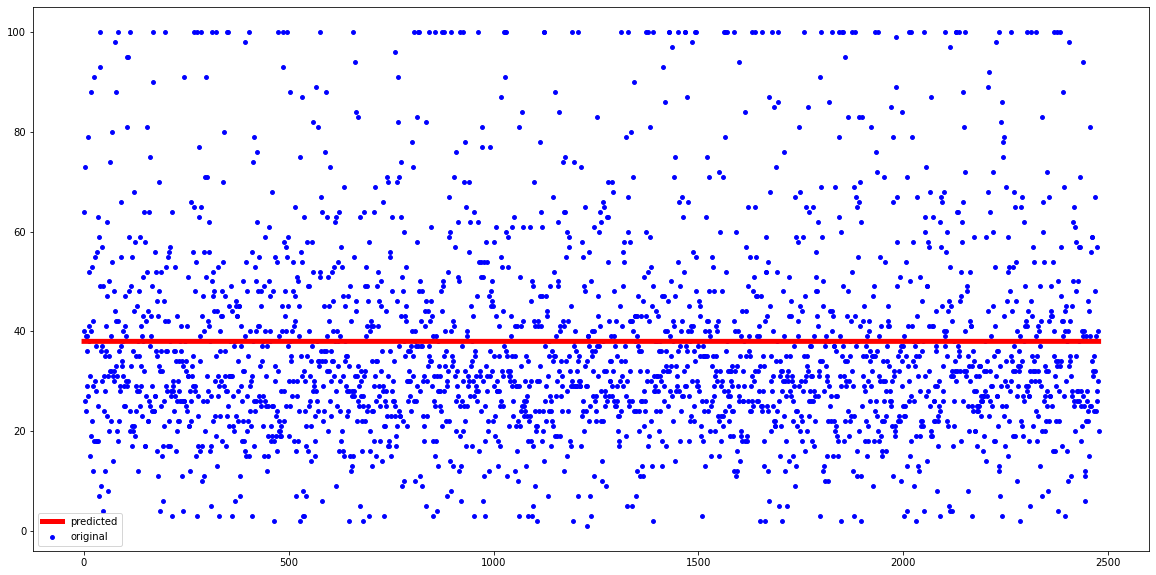

In [256]:
ypred = baseline.predict(X_test)
x_ax = range(len(ypred))
plt.figure(figsize=(20,10))
plt.scatter(x_ax, y_test, s=15, color="blue", label="original")
plt.plot(x_ax, ypred, lw=5, color="red", label="predicted")
plt.legend()
plt.show()

> First Models

In [278]:
ann1 = Sequential([
        Flatten(),
        Dense(1, activation='relu')
      ])

model_compfit(ann1, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 1s 4ms/step - loss: 1664.8774 - mse: 1664.8774
Epoch 2/10
233/233 [==============================] - 1s 4ms/step - loss: 1327.2026 - mse: 1327.2026
Epoch 3/10
233/233 [==============================] - 1s 4ms/step - loss: 1066.9049 - mse: 1066.9049
Epoch 4/10
233/233 [==============================] - 1s 4ms/step - loss: 871.9034 - mse: 871.9034
Epoch 5/10
233/233 [==============================] - 1s 3ms/step - loss: 730.8287 - mse: 730.8287
Epoch 6/10
233/233 [==============================] - 1s 4ms/step - loss: 632.1949 - mse: 632.1949
Epoch 7/10
233/233 [==============================] - 1s 4ms/step - loss: 566.4428 - mse: 566.4428
Epoch 8/10
233/233 [==============================] - 1s 4ms/step - loss: 525.2294 - mse: 525.2294
Epoch 9/10
233/233 [==============================] - 1s 4ms/step - loss: 500.7701 - mse: 500.7701
Epoch 10/10
233/233 [==============================] - 1s 4ms/step - loss: 487.2275 - mse: 487.2275


78/78 [==============================] - 0s 2ms/step - loss: 506.4355 - mse: 506.4355

    First ANN Training Metrics:
    Loss: 482.846
    Root Mean Square Error: 482.846
    Cross Validation Score: 
    ------
    First ANN Test Metrics:
    Loss: 506.436
    Root Mean Square Error: 506.436
    


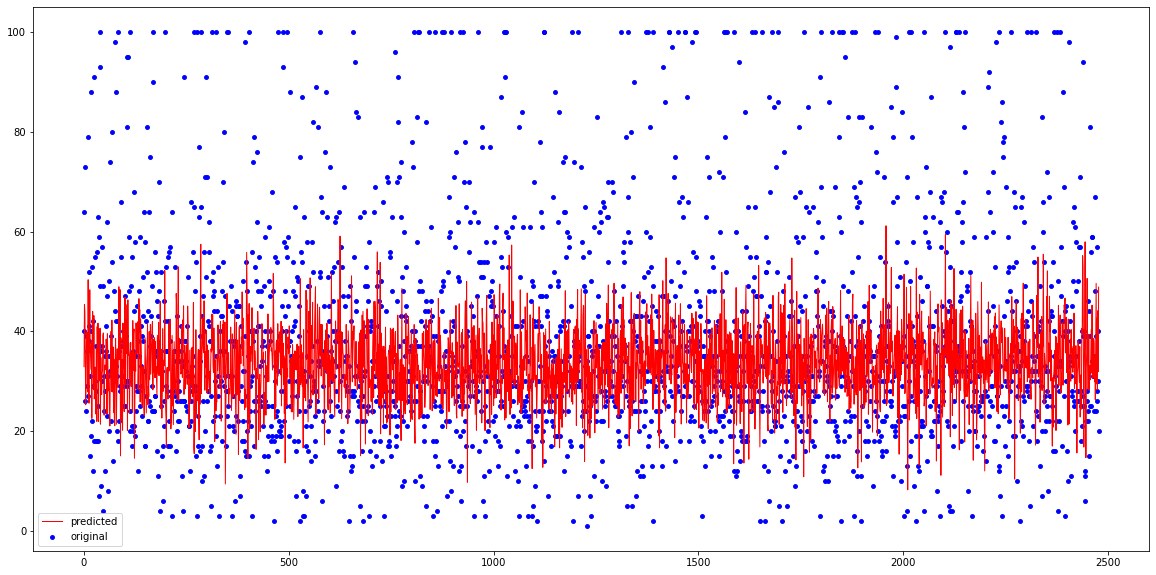

In [286]:
model_eval(ann1, X_train, y_train, X_test, y_test, 'First ANN')

In [197]:
ann2 = Sequential([
        Flatten(),
        Dense(1000, activation='relu'),
        Dense(1, activation='relu')
      ])

model_compfit(ann2, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 29s 123ms/step - loss: 583.2039 - root_mean_squared_error: 24.1496
Epoch 2/10
233/233 [==============================] - 27s 114ms/step - loss: 464.5610 - root_mean_squared_error: 21.5537
Epoch 3/10
233/233 [==============================] - 26s 112ms/step - loss: 455.1388 - root_mean_squared_error: 21.3340
Epoch 4/10
233/233 [==============================] - 26s 111ms/step - loss: 446.1477 - root_mean_squared_error: 21.1222
Epoch 5/10
233/233 [==============================] - 27s 118ms/step - loss: 437.4955 - root_mean_squared_error: 20.9164
Epoch 6/10
233/233 [==============================] - 28s 121ms/step - loss: 429.7646 - root_mean_squared_error: 20.7308
Epoch 7/10
233/233 [==============================] - 27s 118ms/step - loss: 423.4160 - root_mean_squared_error: 20.5771
Epoch 8/10
233/233 [==============================] - 28s 119ms/step - loss: 420.4710 - root_mean_squared_error: 20.5054
Epoch 9/10
233/233 [============

78/78 [==============================] - 2s 29ms/step - loss: 446.7664 - root_mean_squared_error: 21.1368

    Second ANN Training Metrics:
    Loss: 411.782
    Root Mean Square Error: 20.292
    ------
    Second ANN Test Metrics:
    Loss: 446.766
    Root Mean Square Error: 21.137
    


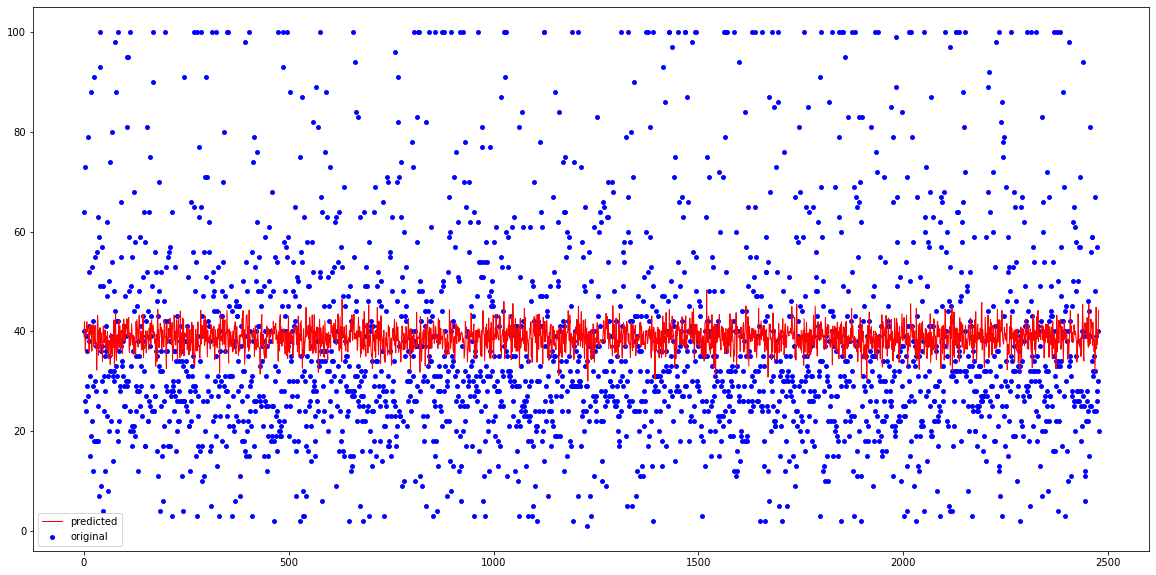

In [261]:
model_eval(ann2, X_train, y_train, X_test, y_test, 'Second ANN')

In [199]:
ann3 = Sequential([
        Flatten(),
        Dense(3000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(10, activation='relu')
      ])

model_compfit(ann3, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 80s 344ms/step - loss: 658.5952 - root_mean_squared_error: 25.6631
Epoch 2/10
233/233 [==============================] - 81s 347ms/step - loss: 589.1725 - root_mean_squared_error: 24.2729
Epoch 3/10
233/233 [==============================] - 85s 366ms/step - loss: 581.8032 - root_mean_squared_error: 24.1206
Epoch 4/10
233/233 [==============================] - 84s 360ms/step - loss: 570.5612 - root_mean_squared_error: 23.8864
Epoch 5/10
233/233 [==============================] - 80s 341ms/step - loss: 565.3359 - root_mean_squared_error: 23.7768
Epoch 6/10
233/233 [==============================] - 79s 339ms/step - loss: 567.7137 - root_mean_squared_error: 23.8267
Epoch 7/10
233/233 [==============================] - 80s 343ms/step - loss: 561.9400 - root_mean_squared_error: 23.7053
Epoch 8/10
233/233 [==============================] - 82s 352ms/step - loss: 563.8669 - root_mean_squared_error: 23.7459
Epoch 9/10
233/233 [============

78/78 [==============================] - 8s 102ms/step - loss: 603.1640 - root_mean_squared_error: 24.5594

    Third ANN Training Metrics:
    Loss: 554.87
    Root Mean Square Error: 23.556
    ------
    Third ANN Test Metrics:
    Loss: 603.164
    Root Mean Square Error: 24.559
    


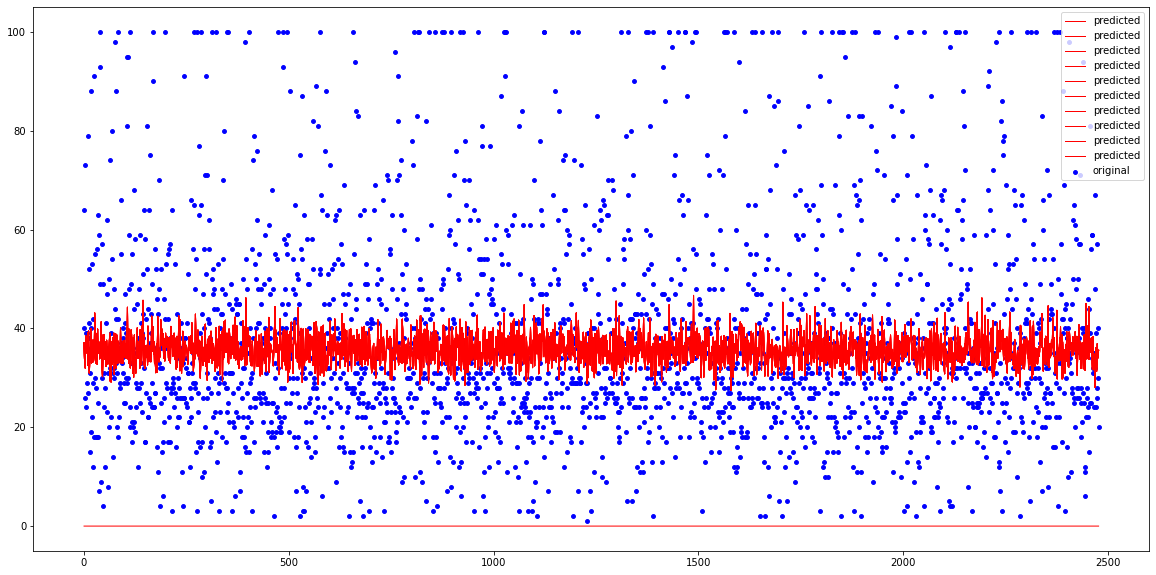

In [262]:
model_eval(ann3, X_train, y_train, X_test, y_test, 'Third ANN')

In [203]:
ann4 = Sequential([
        Flatten(input_shape=(64, 64, 3)),
        Dense(units=128, activation='relu'),
        Dense(units=1, activation='relu')
])

model_compfit(ann4, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 5s 21ms/step - loss: 772.4452 - root_mean_squared_error: 27.7929
Epoch 2/10
233/233 [==============================] - 5s 21ms/step - loss: 472.6698 - root_mean_squared_error: 21.7410 0s - loss: 467.2359 - root_mean_squa
Epoch 3/10
233/233 [==============================] - 5s 21ms/step - loss: 468.2150 - root_mean_squared_error: 21.6383
Epoch 4/10
233/233 [==============================] - 5s 21ms/step - loss: 463.9624 - root_mean_squared_error: 21.5398
Epoch 5/10
233/233 [==============================] - 5s 21ms/step - loss: 459.4706 - root_mean_squared_error: 21.4353
Epoch 6/10
233/233 [==============================] - 5s 20ms/step - loss: 456.0626 - root_mean_squared_error: 21.3556
Epoch 7/10
233/233 [==============================] - 5s 21ms/step - loss: 453.0230 - root_mean_squared_error: 21.2843 3s - loss: 455.8302 - root_mean_squared_error: 2 - ETA: 2s - loss: 460.052 - ETA: 1s - loss: 455.0986 - root_mean_square - ETA: 1s

78/78 [==============================] - 0s 6ms/step - loss: 467.2998 - root_mean_squared_error: 21.6171

    Fourth ANN Training Metrics:
    Loss: 439.383
    Root Mean Square Error: 20.961
    ------
    Fourth ANN Test Metrics:
    Loss: 467.3
    Root Mean Square Error: 21.617
    


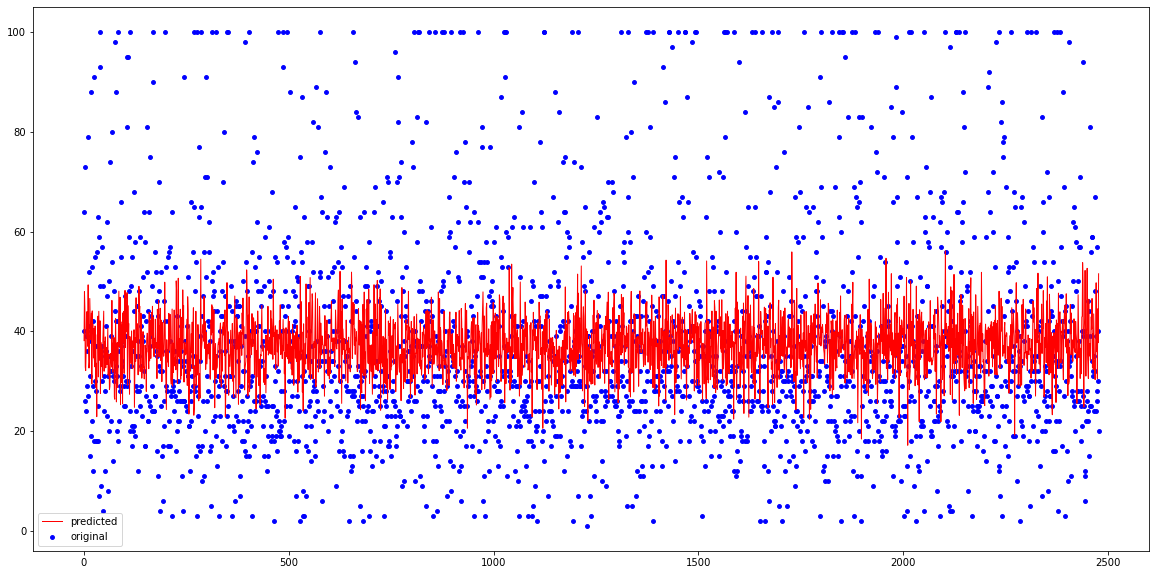

In [263]:
model_eval(ann4, X_train, y_train, X_test, y_test, 'Fourth ANN')

In [204]:
ann5 = tf.keras.Sequential([
        Flatten(input_shape=(64, 64, 3)),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=1, activation='relu')
])

model_compfit(ann5, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 5s 22ms/step - loss: 644.7858 - root_mean_squared_error: 25.3926
Epoch 2/10
233/233 [==============================] - 5s 21ms/step - loss: 464.9090 - root_mean_squared_error: 21.5617 0s - loss: 462.9344 - root_m
Epoch 3/10
233/233 [==============================] - 5s 22ms/step - loss: 454.9872 - root_mean_squared_error: 21.3304
Epoch 4/10
233/233 [==============================] - 5s 22ms/step - loss: 445.5803 - root_mean_squared_error: 21.1088
Epoch 5/10
233/233 [==============================] - 5s 22ms/step - loss: 437.7360 - root_mean_squared_error: 20.9221
Epoch 6/10
233/233 [==============================] - 5s 22ms/step - loss: 430.3928 - root_mean_squared_error: 20.7459 0s - loss: 431.3883 - root_mean_squared_error: 20. - ETA: 0s - loss: 432.0047 - root_mean_squared_error: 20.
Epoch 7/10
233/233 [==============================] - 5s 22ms/step - loss: 426.2508 - root_mean_squared_error: 20.6458
Epoch 8/10
233/233 [=========

78/78 [==============================] - 0s 6ms/step - loss: 453.2886 - root_mean_squared_error: 21.2906

    Fifth ANN Training Metrics:
    Loss: 418.549
    Root Mean Square Error: 20.458
    ------
    Fifth ANN Test Metrics:
    Loss: 453.289
    Root Mean Square Error: 21.291
    


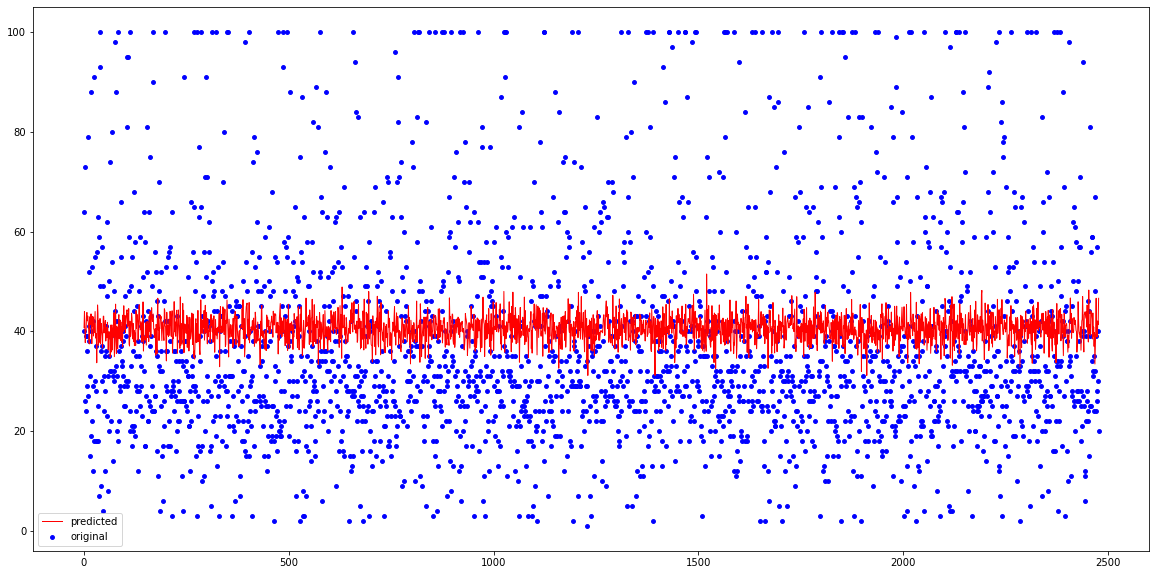

In [264]:
model_eval(ann5, X_train, y_train, X_test, y_test, 'Fifth ANN')

In [207]:
CNN = Sequential([
        Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (4, 4), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='relu'),
])

model_compfit(CNN, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 38s 165ms/step - loss: 524.8223 - root_mean_squared_error: 22.9090
Epoch 2/10
233/233 [==============================] - 37s 160ms/step - loss: 425.5045 - root_mean_squared_error: 20.6278
Epoch 3/10
233/233 [==============================] - 38s 163ms/step - loss: 426.0818 - root_mean_squared_error: 20.6418s -
Epoch 4/10
233/233 [==============================] - 39s 166ms/step - loss: 425.2364 - root_mean_squared_error: 20.6213
Epoch 5/10
233/233 [==============================] - 38s 161ms/step - loss: 427.7728 - root_mean_squared_error: 20.6827
Epoch 6/10
233/233 [==============================] - 36s 154ms/step - loss: 423.1820 - root_mean_squared_error: 20.5714
Epoch 7/10
233/233 [==============================] - 36s 153ms/step - loss: 425.6275 - root_mean_squared_error: 20.6307
Epoch 8/10
233/233 [==============================] - 37s 157ms/step - loss: 424.5296 - root_mean_squared_error: 20.6041
Epoch 9/10
233/233 [=========

78/78 [==============================] - 3s 39ms/step - loss: 444.9490 - root_mean_squared_error: 21.0938

    CNN Training Metrics:
    Loss: 417.805
    Root Mean Square Error: 20.44
    ------
    CNN Test Metrics:
    Loss: 444.949
    Root Mean Square Error: 21.094
    


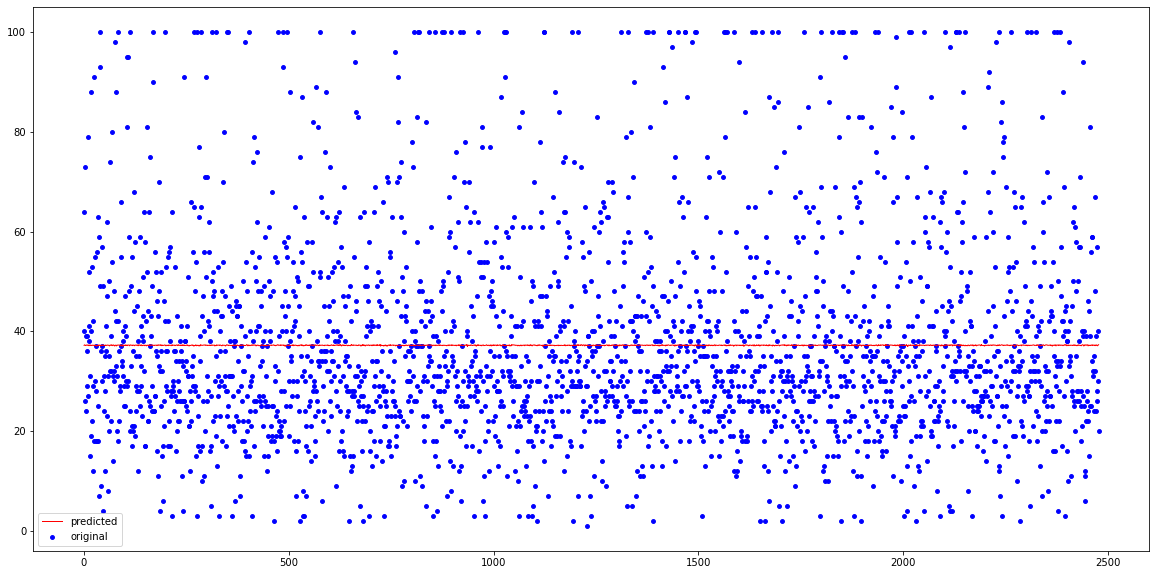

In [266]:
model_eval(CNN, X_train, y_train, X_test, y_test, 'First CNN')

In [292]:
CNN2 = Sequential([
        Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='relu'),
])

model_compfit(CNN2, X_train, y_train, 10)

Epoch 1/10
140/233 [=================>............] - ETA: 10s - loss: 533.3203 - root_mean_squared_error: 23.0937

KeyboardInterrupt: 

78/78 [==============================] - 2s 30ms/step - loss: 443.8628 - root_mean_squared_error: 21.0681

    CNN Training Metrics:
    Loss: 417.331
    Root Mean Square Error: 20.429
    ------
    CNN Test Metrics:
    Loss: 443.863
    Root Mean Square Error: 21.068
    


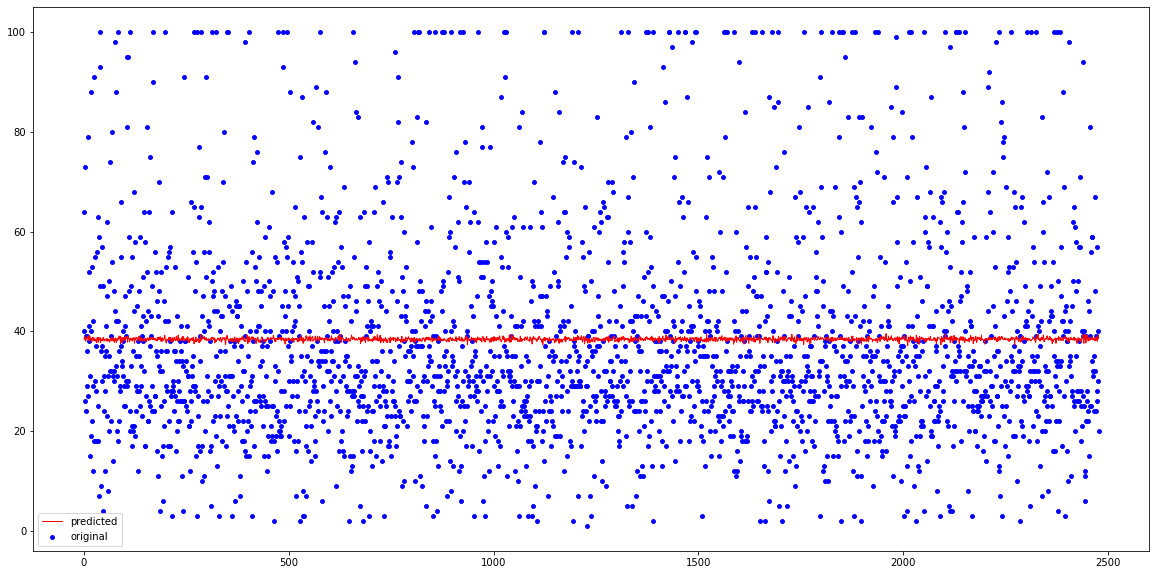

In [267]:
model_eval(CNN2, X_train, y_train, X_test, y_test, 'Second CNN')

In [297]:
CNN3 = Sequential([
        Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64, 3)),
        MaxPooling2D((2, 2)),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(1, activation=None),
])

model_compfit(CNN3, X_train, y_train, 10)

Epoch 1/10
233/233 [==============================] - 62s 266ms/step - loss: 531.9791 - root_mean_squared_error: 23.0647
Epoch 2/10
233/233 [==============================] - 54s 230ms/step - loss: 424.0051 - root_mean_squared_error: 20.5914
Epoch 3/10
233/233 [==============================] - 52s 225ms/step - loss: 420.8993 - root_mean_squared_error: 20.5158
Epoch 4/10
233/233 [==============================] - 52s 222ms/step - loss: 421.7113 - root_mean_squared_error: 20.5356
Epoch 5/10
233/233 [==============================] - 52s 223ms/step - loss: 420.2224 - root_mean_squared_error: 20.4993
Epoch 6/10
233/233 [==============================] - 56s 239ms/step - loss: 420.3940 - root_mean_squared_error: 20.5035
Epoch 7/10
233/233 [==============================] - 52s 223ms/step - loss: 421.9083 - root_mean_squared_error: 20.5404
Epoch 8/10
233/233 [==============================] - 52s 221ms/step - loss: 420.8546 - root_mean_squared_error: 20.5147
Epoch 9/10
233/233 [============

78/78 [==============================] - 5s 62ms/step - loss: 474.7434 - root_mean_squared_error: 21.7886

    Third CNN Training Metrics:
    Loss: 446.422
    Root Mean Square Error: 21.129
    Cross Validation Score: 
    ------
    Third CNN Test Metrics:
    Loss: 474.743
    Root Mean Square Error: 21.789
    


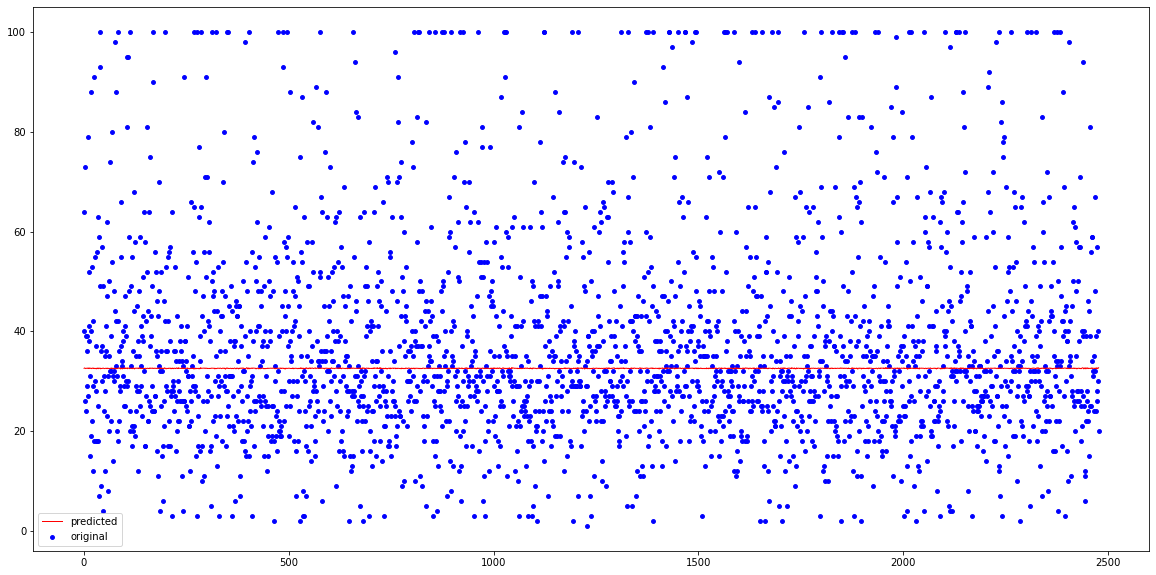

In [298]:
model_eval(CNN3, X_train, y_train, X_test, y_test, 'Third CNN')